# OECD Better Life Index and GDP data cleaning

inspired by https://kirenz.github.io/regression/docs/ds-happy-stats.html


In [17]:
import pandas as pd

In [18]:
datafilepath = "../datasets/oecd_bli.csv"

## Better Life Index data

In [19]:
rawblifile = "../datasets/raw/OECD/rawdata-2024-03-07-bli.csv"
rawbli = pd.read_csv(rawblifile)


indicators = {
    'Household net adjusted disposable income':"income",
    'Life satisfaction':"lifesat",
    'Personal earnings':"salary",
    'Educational attainment':"educ",
}

bli = (rawbli[ (rawbli["Indicator"].isin(indicators.keys())) &
               (rawbli["INEQUALITY"] == "TOT")] 
        [["Country","Indicator","Value"]] 
        .pivot(index="Country", columns="Indicator", values="Value") 
        .rename(columns=indicators)
      )
bli.head()

Indicator,educ,income,lifesat,salary
Country,,,,
Australia,84.0,37433.0,7.1,55206.0
Austria,86.0,37001.0,7.2,53132.0
Belgium,80.0,34884.0,6.8,54327.0
Brazil,57.0,NaN,6.1,NaN
Canada,92.0,34421.0,7.0,55342.0


## GDP data

In [20]:
rawgdpfile = "../datasets/raw/OECD/rawdata-2024-03-07-gdp.csv"
rawgdp = pd.read_csv(rawgdpfile)

gdp = (rawgdp
        .sort_values('TIME') 
        .groupby('Country') 
        .tail(1)
        .loc[:, ["Country", "Value"]]
        .assign(Value=lambda df_: df_["Value"].round())
      )
# latestgdp.loc[:, :].sort_values("Reference area").head(30).iloc[0]
gdp.head()

,Country,Value
151,Russia,29819.0
147,India,6705.0
235,South Africa,15953.0
253,Iceland,71841.0
17,Belgium,68287.0


## Merge

In [21]:
oecd_bli = (bli.merge(gdp, on="Country", how="inner") 
                 .rename(columns={"Value":"gdp"}) 
                 .sort_values("gdp")
                 .iloc[0:-3,:]
                 .dropna()
             )
oecd_bli.head()

,Country,educ,income,lifesat,salary,gdp
21,Mexico,42.0,16269.0,6.0,16230.0,23659.0
12,Greece,76.0,20791.0,5.8,27207.0,38397.0
29,Slovak Republic,92.0,21149.0,6.5,23619.0,40586.0
13,Hungary,86.0,21026.0,6.0,25409.0,43476.0
27,Portugal,55.0,24877.0,5.8,28410.0,44963.0


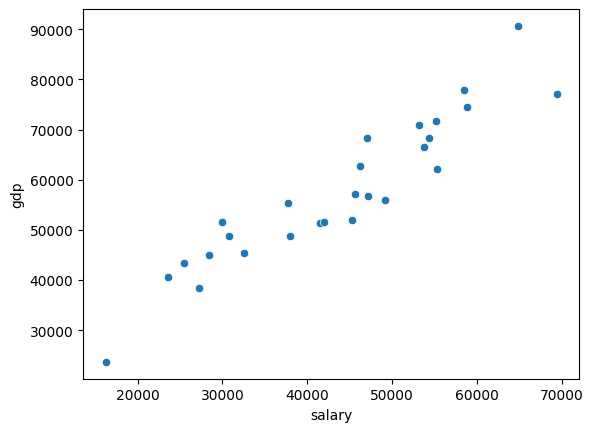

In [22]:
import seaborn as sns
sns.scatterplot(data=oecd_bli, x="salary", y="gdp");

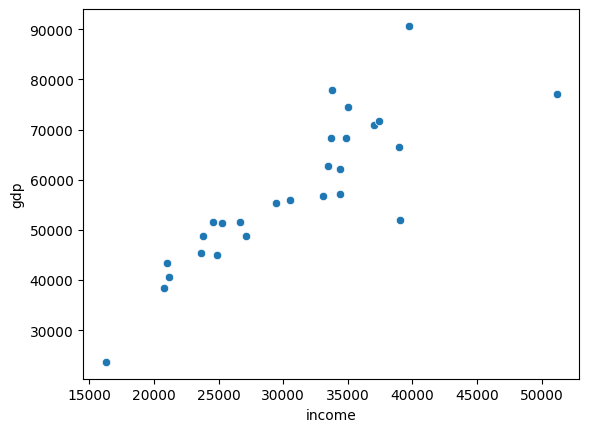

In [23]:
sns.scatterplot(data=oecd_bli, x="income", y="gdp");

<Axes: xlabel='salary', ylabel='lifesat'>

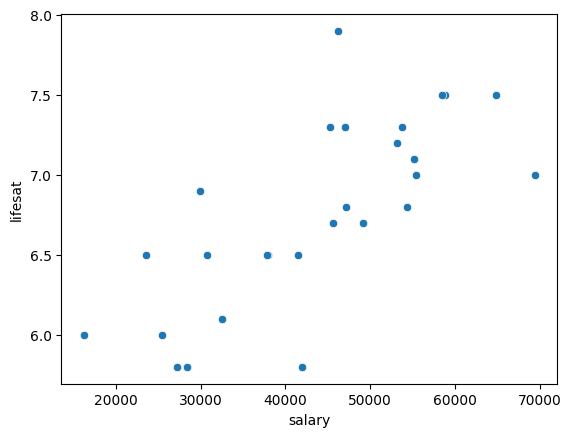

In [24]:
sns.scatterplot(data=oecd_bli, x="salary", y="lifesat")

In [25]:
import statsmodels.formula.api as smf
#######################################################
model1 = smf.ols('gdp ~ 1 + lifesat', data=oecd_bli)
fit1 = model1.fit()

fit1.params

Intercept   -73311.890399
lifesat      19377.660497
dtype: float64

In [26]:
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gdp   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     38.83
Date:                Sat, 09 Mar 2024   Prob (F-statistic):           1.61e-06
Time:                        07:25:20   Log-Likelihood:                -284.02
No. Observations:                  27   AIC:                             572.0
Df Residuals:                      25   BIC:                             574.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.331e+04   2.11e+04     -3.475      0.002   -1.17e+05   -2.99e+04
lifesat     1.938e+04   3109.556      6.232      0.000     1.3e+04    2.58e+04
==============================================================================
Omnibus:                        0.774   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.679   Jarque-Bera (JB):                0.318
Skew:                          -0.265   Prob(JB):                        0.853
Kurtosis:                       3.034   Cond. No.                         81.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# SAVE TO DATAFILE
oecd_bli.to_csv(datafilepath, index=False)

In [ ]:
sns.pairplot(data=oecd_bli, diag_kws=dict(bins=20));

In [ ]:
sns.jointplot(data=oecd_bli, x="lifesat", y="gdp")